In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import compose
import pathlib

Using TensorFlow backend.


In [2]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [3]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [4]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [5]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
def yield_batch(data):
    votes, answers = data
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, 1)
        forecasts = votes.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts.sample(len(forecasts))
        y[0] = answers.loc[item_id]
        yield x, y

In [7]:
def yield_batch_val(data):
    votes, answers = data
    item_ids = set(votes.index)
    while True:
        for item_id in item_ids:
            forecasts = votes.loc[item_id]
            x = np.zeros((1, *forecasts.shape))
            y = np.zeros((1, 4))

            x[0] = forecasts
            y[0] = answers.loc[item_id]
            yield x, y

In [8]:
def yield_batch_test(data):
    item_ids = data.index.unique()
    for item_id in item_ids:
        forecasts = data.loc[item_id]
        x = np.zeros((1, *forecasts.shape))
        y = np.zeros((1, 4))
        x[0] = forecasts
        yield x

In [9]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [110]:
def make_model(filters, input_shape, conv_l=6):
    K.clear_session()
    
    y = x = layers.Input(shape=(None, input_shape))
    
    y_hot = layers.Lambda(lambda z: z[:, :, :-4])(y)
    y_coor = layers.Lambda(lambda z: z[:, :, -4:])(y)
    
    y_hot = layers.Conv1D(
            filters=1,
            kernel_size=1,
            strides=1,
            padding="same",
            activation=None
        )(y_hot)
    y = layers.concatenate([y_hot, y_coor])
    
    for i in range(conv_l):
        y = layers.Conv1D(
            filters=filters,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="relu"
        )(y)
        
    y = layers.Conv1D(
        filters=4,
        kernel_size=1,
        strides=1,
        padding="same",
        activation=None
    )(y)
    
    y = layers.GlobalAveragePooling1D()(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [11]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [12]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1, epsilon=0.0001, wait=3):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        self.epsilon=epsilon
        self.wait=wait
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None
        
        self.wait_count=None
        self.prev_loss=None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0.0
        self.d_loss = 0.0
        self.d_iterations = 0.0
        self.d_iterations2 = 0.0
        self.d_1 = 0.0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        self.wait_count=0
        self.prev_loss=None
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        
        if self.prev_loss is None:
            self.prev_loss = logs["val_loss"]
        elif abs(self.prev_loss - logs["val_loss"]) < self.epsilon:
            self.wait_count += 1
        else:
            self.wait_count = 0
        self.prev_loss = logs["val_loss"]
        print(f"Wait to stop: {self.wait - self.wait_count}\n")
        if self.wait == self.wait_count:
            self.model.stop_training = True
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [115]:
def train_model(data_train, data_val, units, test=False):
    
    max_lr = 7.9e-04
    
    steps_per_epoch = 1000
    epochs = 100
    
    model = make_model(units, data_train[0].shape[1])  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=len(data_val[1].index),
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model3.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=len(data_val[1].index),
        )
    
    model = models.load_model("../processed/model3.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 31)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 27)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 1)      28          lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 4)      0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenat

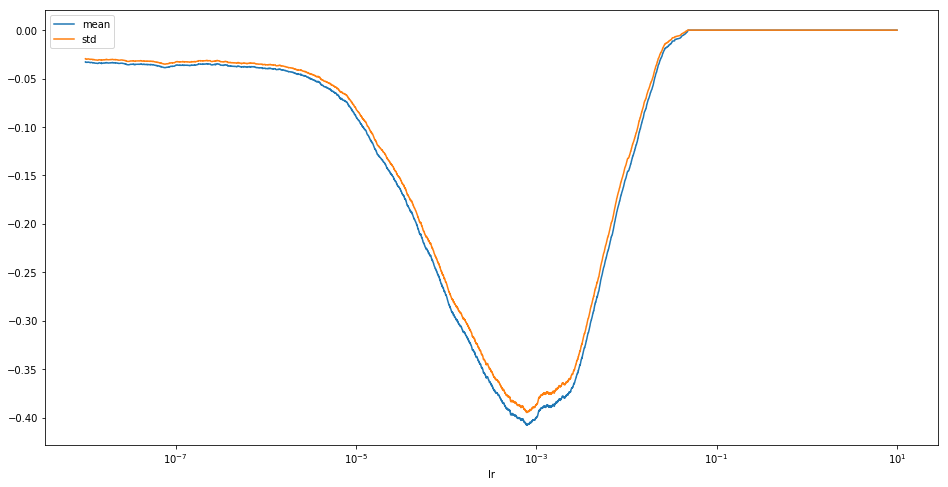

In [114]:
a, *_ = transform(votes, votes, votes)
train_model((a, answers), (a, answers), 64, True)[1].plot()

In [112]:
def transform(train, val, test):
    trans = compose.ColumnTransformer(
        [("onehot_id", preprocessing.OneHotEncoder(handle_unknown="ignore"), [0])],
        remainder="passthrough",
        sparse_threshold=0
    )
    train = pd.DataFrame(trans.fit_transform(train), index=train.index)
    val = pd.DataFrame(trans.transform(val), index=val.index)
    test = pd.DataFrame(trans.transform(test), index=test.index)
    to_drop = []
    for i in train.columns[:-4]:
        if train[i].sum() < 20:
            to_drop.append(i)
    return train.drop(to_drop, axis=1), val.drop(to_drop, axis=1), test.drop(to_drop, axis=1)

In [82]:
FOLDS = 10

def train_oof(train_set, test_set, units=64):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        x_train_t, x_val_t, x_test_t = transform(x_train.loc[ids_train], x_train.loc[ids_valid], x_test)
        
        data_train = (x_train_t, y_train.loc[ids_train])
        data_val = (x_val_t, y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test_t)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {2 * np.std(scores) / len(scores) ** 2:0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)

In [ ]:
train_oof((votes, answers), votes_test)


Fold - 1 / 10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 29)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, 25)     0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 1)      26          lambda_1[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, None, 4)      0           input_1[0][0]                    
______________________________________________________________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3183 - val_loss: -0.3479

Epoch 00001: val_loss improved from inf to -0.34790, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1663
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.3761 - val_loss: -0.3558

Epoch 00002: val_loss improved from -0.34790 to -0.35580, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0518
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4105 - val_loss: -0.3869

Epoch 00003: val_loss improved from -0.35580 to -0.38689, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0290
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4362 - val_loss: -0.4049

Epoch 00004: val_loss improved from -0.38689 to -0.40492, saving model to ../processed/model3.h5
Learning r

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5804 - val_loss: -0.5285

Epoch 00034: val_loss did not improve from -0.53205
Learning rate: 5.1e-05
Speed per epoch: -0.0047
Wait to stop: 3

Epoch 35/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5810 - val_loss: -0.5260

Epoch 00035: val_loss did not improve from -0.53205
Learning rate: 5.1e-05
Speed per epoch: -0.0025
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5865 - val_loss: -0.5237

Epoch 00036: val_loss did not improve from -0.53205
Learning rate: 5.1e-05
Speed per epoch: -0.0016
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5911 - val_loss: -0.5270

Epoch 00037: val_loss did not improve from -0.53205
Learning rate: 4.9e-05
Speed per epoch: -0.0031
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5923 - val_loss: -0.5278

Epoch 0003

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3099 - val_loss: -0.3424

Epoch 00001: val_loss improved from inf to -0.34244, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1932
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3691 - val_loss: -0.3837

Epoch 00002: val_loss improved from -0.34244 to -0.38372, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0554
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4220 - val_loss: -0.4207

Epoch 00003: val_loss improved from -0.38372 to -0.42070, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0529
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4364 - val_loss: -0.4472

Epoch 00004: val_loss improved from -0.42070 to -0.44724, saving model to ../processed/model3.h5
Learning r

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5831 - val_loss: -0.5514

Epoch 00035: val_loss did not improve from -0.55220
Learning rate: 6.0e-05
Speed per epoch: -0.0065
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5768 - val_loss: -0.5493

Epoch 00036: val_loss did not improve from -0.55220
Learning rate: 5.9e-05
Speed per epoch: -0.0006
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5929 - val_loss: -0.5519

Epoch 00037: val_loss did not improve from -0.55220
Learning rate: 5.9e-05
Speed per epoch: -0.0060
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5833 - val_loss: -0.5505

Epoch 00038: val_loss did not improve from -0.55220
Learning rate: 4.2e-05
Speed per epoch: -0.0045
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5873 - val_loss: -0.5531

Epoch 0003

Epoch 1/1
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7743 - intersection_over_union: -0.0013 - val_loss: 0.7290 - val_intersection_over_union: -0.0116
Epoch 1/100
  34/1000 [>.............................] - ETA: 19s - loss: -0.0078

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3034 - val_loss: -0.4311

Epoch 00001: val_loss improved from inf to -0.43108, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1810
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3619 - val_loss: -0.4137

Epoch 00002: val_loss did not improve from -0.43108
Learning rate: 7.9e-04
Speed per epoch: -0.0455
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3823 - val_loss: -0.4529

Epoch 00003: val_loss improved from -0.43108 to -0.45286, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0267
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4083 - val_loss: -0.4188

Epoch 00004: val_loss did not improve from -0.45286
Learning rate: 7.9e-04
Speed per epoch: -0.0279
Wait to stop: 3

Epoch 5/100
1000/1000 [============

1000/1000 [==============================] - 6s 6ms/step - loss: -0.5736 - val_loss: -0.5524

Epoch 00036: val_loss did not improve from -0.55364
Learning rate: 7.3e-05
Speed per epoch: -0.0020
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5776 - val_loss: -0.5500

Epoch 00037: val_loss did not improve from -0.55364
Learning rate: 7.2e-05
Speed per epoch: -0.0020
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5762 - val_loss: -0.5573

Epoch 00038: val_loss improved from -0.55364 to -0.55733, saving model to ../processed/model3.h5
Learning rate: 5.5e-05
Speed per epoch: -0.0003
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5851 - val_loss: -0.5444

Epoch 00039: val_loss did not improve from -0.55733
Learning rate: 5.4e-05
Speed per epoch: -0.0019
Wait to stop: 3

Epoch 40/100
1000/1000 [==============================] - 5s 5ms/step - 

1000/1000 [==============================] - 5s 5ms/step - loss: 0.7288 - intersection_over_union: -0.0171 - val_loss: 0.5920 - val_intersection_over_union: -0.1007
Epoch 1/100
  33/1000 [..............................] - ETA: 20s - loss: -0.0960

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3197 - val_loss: -0.4177

Epoch 00001: val_loss improved from inf to -0.41770, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1452
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3772 - val_loss: -0.3508

Epoch 00002: val_loss did not improve from -0.41770
Learning rate: 7.9e-04
Speed per epoch: -0.0558
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4048 - val_loss: -0.4127

Epoch 00003: val_loss did not improve from -0.41770
Learning rate: 7.9e-04
Speed per epoch: -0.0382
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4097 - val_loss: -0.4712

Epoch 00004: val_loss improved from -0.41770 to -0.47122, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0172
Wait to stop: 3

Epoch 5/100
1000/1000 [============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5701 - val_loss: -0.5553

Epoch 00035: val_loss did not improve from -0.55914
Learning rate: 7.1e-05
Speed per epoch: -0.0019
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5791 - val_loss: -0.5592

Epoch 00036: val_loss improved from -0.55914 to -0.55918, saving model to ../processed/model3.h5
Learning rate: 6.9e-05
Speed per epoch: -0.0050
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.5807 - val_loss: -0.5549

Epoch 00037: val_loss did not improve from -0.55918
Learning rate: 6.6e-05
Speed per epoch: -0.0045
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5831 - val_loss: -0.5569

Epoch 00038: val_loss did not improve from -0.55918
Learning rate: 6.4e-05
Speed per epoch: -0.0053
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - 

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.2916 - val_loss: -0.3836

Epoch 00001: val_loss improved from inf to -0.38357, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.2416
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3687 - val_loss: -0.3938

Epoch 00002: val_loss improved from -0.38357 to -0.39378, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0638
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4001 - val_loss: -0.3601

Epoch 00003: val_loss did not improve from -0.39378
Learning rate: 7.9e-04
Speed per epoch: -0.0347
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 6s 6ms/step - loss: -0.4162 - val_loss: -0.4035

Epoch 00004: val_loss improved from -0.39378 to -0.40353, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0232
Wait to

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5876 - val_loss: -0.5141

Epoch 00034: val_loss did not improve from -0.52104
Learning rate: 7.2e-05
Speed per epoch: -0.0057
Wait to stop: 3

Epoch 35/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5893 - val_loss: -0.5151

Epoch 00035: val_loss did not improve from -0.52104
Learning rate: 7.2e-05
Speed per epoch: -0.0049
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5882 - val_loss: -0.5198

Epoch 00036: val_loss did not improve from -0.52104
Learning rate: 6.1e-05
Speed per epoch: -0.0036
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5801 - val_loss: -0.5214

Epoch 00037: val_loss improved from -0.52104 to -0.52144, saving model to ../processed/model3.h5
Learning rate: 4.0e-05
Speed per epoch: 0.0042
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - l

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3055 - val_loss: -0.3048

Epoch 00001: val_loss improved from inf to -0.30480, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1703
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3814 - val_loss: -0.4316

Epoch 00002: val_loss improved from -0.30480 to -0.43161, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0683
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4082 - val_loss: -0.3736

Epoch 00003: val_loss did not improve from -0.43161
Learning rate: 7.9e-04
Speed per epoch: -0.0402
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4255 - val_loss: -0.4204

Epoch 00004: val_loss did not improve from -0.43161
Learning rate: 7.9e-04
Speed per epoch: -0.0289
Wait to stop: 3

Epoch 5/100
1000/1000 [============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5809 - val_loss: -0.5602

Epoch 00035: val_loss did not improve from -0.56416
Learning rate: 3.5e-05
Speed per epoch: -0.0058
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5772 - val_loss: -0.5593

Epoch 00036: val_loss did not improve from -0.56416
Learning rate: 3.5e-05
Speed per epoch: -0.0034
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5871 - val_loss: -0.5592

Epoch 00037: val_loss did not improve from -0.56416
Learning rate: 3.5e-05
Speed per epoch: -0.0030
Wait to stop: 2

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5832 - val_loss: -0.5577

Epoch 00038: val_loss did not improve from -0.56416
Learning rate: 3.5e-05
Speed per epoch: -0.0003
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5858 - val_loss: -0.5661

Epoch 0003

1000/1000 [==============================] - 5s 5ms/step - loss: 0.7750 - intersection_over_union: -0.0072 - val_loss: 0.6733 - val_intersection_over_union: -0.0478
Epoch 1/100
  40/1000 [>.............................] - ETA: 15s - loss: -0.0696

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 5s 5ms/step - loss: -0.2960 - val_loss: -0.4268

Epoch 00001: val_loss improved from inf to -0.42677, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.1763
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3906 - val_loss: -0.4216

Epoch 00002: val_loss did not improve from -0.42677
Learning rate: 7.9e-04
Speed per epoch: -0.0799
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4203 - val_loss: -0.4810

Epoch 00003: val_loss improved from -0.42677 to -0.48099, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0452
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4127 - val_loss: -0.4355

Epoch 00004: val_loss did not improve from -0.48099
Learning rate: 7.9e-04
Speed per epoch: -0.0185
Wait to stop: 3

Epoch 5/100
1000/1000 [============

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5828 - val_loss: -0.5723

Epoch 00035: val_loss did not improve from -0.57826
Learning rate: 7.0e-05
Speed per epoch: -0.0031
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5747 - val_loss: -0.5721

Epoch 00036: val_loss did not improve from -0.57826
Learning rate: 5.4e-05
Speed per epoch: 0.0019
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5809 - val_loss: -0.5683

Epoch 00037: val_loss did not improve from -0.57826
Learning rate: 4.1e-05
Speed per epoch: 0.0009
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5778 - val_loss: -0.5727

Epoch 00038: val_loss did not improve from -0.57826
Learning rate: 2.3e-05
Speed per epoch: -0.0007
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5827 - val_loss: -0.5786

Epoch 00039:

1000/1000 [==============================] - 5s 5ms/step - loss: 0.6945 - intersection_over_union: -0.0411 - val_loss: 0.5716 - val_intersection_over_union: -0.1480
Epoch 1/100
  34/1000 [>.............................] - ETA: 19s - loss: -0.1581

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 6s 6ms/step - loss: -0.3297 - val_loss: -0.3413

Epoch 00001: val_loss improved from inf to -0.34133, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0984
Wait to stop: 3

Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3933 - val_loss: -0.3671

Epoch 00002: val_loss improved from -0.34133 to -0.36715, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0550
Wait to stop: 3

Epoch 3/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.3992 - val_loss: -0.3176

Epoch 00003: val_loss did not improve from -0.36715
Learning rate: 7.9e-04
Speed per epoch: -0.0280
Wait to stop: 3

Epoch 4/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.4445 - val_loss: -0.4256

Epoch 00004: val_loss improved from -0.36715 to -0.42564, saving model to ../processed/model3.h5
Learning rate: 7.9e-04
Speed per epoch: -0.0346
Wait to

1000/1000 [==============================] - 5s 5ms/step - loss: -0.5894 - val_loss: -0.4961

Epoch 00035: val_loss did not improve from -0.50412
Learning rate: 8.3e-05
Speed per epoch: -0.0081
Wait to stop: 3

Epoch 36/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5855 - val_loss: -0.5074

Epoch 00036: val_loss improved from -0.50412 to -0.50742, saving model to ../processed/model3.h5
Learning rate: 8.2e-05
Speed per epoch: -0.0022
Wait to stop: 3

Epoch 37/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5829 - val_loss: -0.4996

Epoch 00037: val_loss did not improve from -0.50742
Learning rate: 4.8e-05
Speed per epoch: -0.0015
Wait to stop: 3

Epoch 38/100
1000/1000 [==============================] - 5s 5ms/step - loss: -0.5926 - val_loss: -0.4942

Epoch 00038: val_loss did not improve from -0.50742
Learning rate: 4.8e-05
Speed per epoch: -0.0039
Wait to stop: 3

Epoch 39/100
1000/1000 [==============================] - 5s 5ms/step - 